In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc

In [99]:
# params
nx = 500
ny = 500
nz = 50
dx = 2000
dy = 2000

loc = "/scratch/hcm7920/amb"
conc = [0]

levs = [0,7,14,21]
ts   = np.array(range(100,101))
nSnapshots = len(ts)
nLevs = len(levs)

In [100]:
# initialize arrays
ctrV = np.zeros(shape=(len(conc),nSnapshots,nLevs,ny-2,nx-2))
ctrU = np.zeros(shape=(len(conc),nSnapshots,nLevs,ny-2,nx-2))

In [121]:
# load and process data
for ic in range(len(conc)):
    data = nc.Dataset(loc+str(conc[ic])+"/data/state.nc")
    u = data["U"]
    v = data["V"]
    depth = data["Z"]
    
#     dvdx = (v[ts,levs,2:-2,2:-1]-v[ts,levs,2:-2,1:-2])/(dx)
#     dudy = (u[ts,levs,2:-1,2:-2]-u[ts,levs,1:-2,2:-2])/(dy)
#     vortSnapshots[ic,0,:,:,:] = (dvdx-dudy)
    
    u = u[ts,levs,:,:] - u[ts,levs,:,:].mean((3,))[:,:,:,np.newaxis]
    ctrU[ic,:,:,:,:] = (u[:,:,1:-1,2:-1]+u[:,:,1:-1,1:-2])/2
    ctrV[ic,:,:,:,:] = (v[ts,levs,1:-2,1:-1]+v[ts,levs,2:-1,1:-1])/2

Text(0.5, 1.0, 'Window function options')

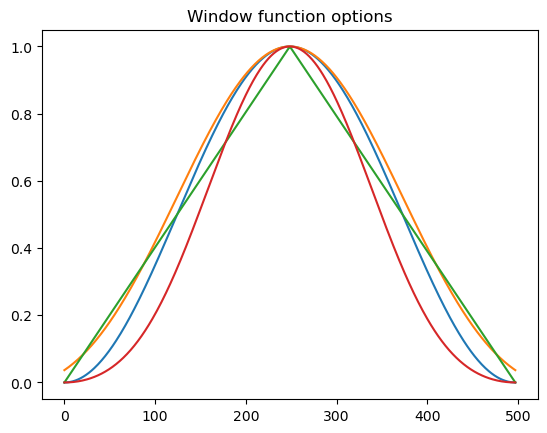

In [122]:
# show some window functions
windowHanning = np.hanning(ny-2)[np.newaxis,np.newaxis,np.newaxis,:,np.newaxis]
plt.plot(np.hanning(ny-2))
plt.plot(np.kaiser(ny-2,5))
plt.plot(np.bartlett(ny-2))
plt.plot(np.blackman(ny-2))
plt.title("Window function options")

In [123]:
# apply window function on u,v
ctrU *= windowHanning
ctrV *= windowHanning

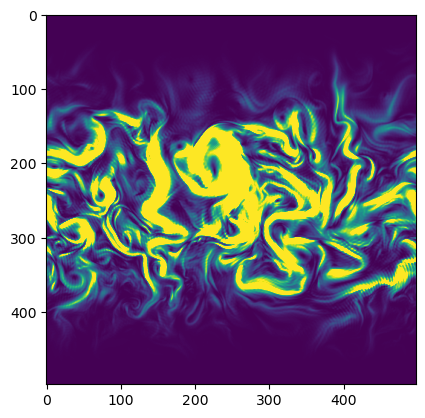

In [124]:
# show new KE field
newKE = ctrU**2 + ctrV**2
plt.imshow(newKE[0,0,0,:,:], vmax=0.1*newKE.max())

In [125]:
# perform 2D fft, get wavenumbers
spectralV = np.fft.fftn(ctrV, axes=(-1,-2))
spectralU = np.fft.fftn(ctrU, axes=(-1,-2))
waveNum1D = np.fft.fftfreq(ny-2, d=2) # 2 km between samples
waveNum2D = np.abs(np.meshgrid(waveNum1D, waveNum1D))**2
waveNum2D = np.sqrt(waveNum2D.sum((0,)))

In [126]:
# calculate spectral KE
sKE = 0.5*(spectralV**2 + spectralU**2)
sKE = np.abs(sKE)

# get histogram bins
binEdges = np.arange(0., (ny-2)//2+1, 2.)/2000 # spaced 2km apart apart
binCenters = (binEdges[:-1]+binEdges[1:])/2

In [127]:
# initialize save array
sKEbinned = np.zeros(shape=(len(conc),nSnapshots,nLevs,len(binEdges)-1))
numVals  = np.zeros(shape=(len(conc),nSnapshots,nLevs,len(binEdges)-1))

In [128]:
# we will use histogram functionality for summing & binning

for ic in range(len(conc)):
    for it in range(nSnapshots):
        for iz in range(nLevs):
            sKEbinned[ic,it,iz,:],edgeOut = np.histogram(waveNum2D,
                                                         bins=binEdges,
                                                         weights=sKE[ic,it,iz,:,:])
            numVals[ic,it,iz,:], edgeOut = np.histogram(waveNum2D,
                                                        bins=binEdges)
            

# Note that the max wavenumber with good stats:
# = 0.5 * smallest grid dim / length in that dim
# = 0.5 * 500 / 1000km = 0.25 1/km


In [129]:
# do averaging to see if it makes a difference

# average value in a bin
powerSpectrum = sKEbinned/numVals

# multiply by integration area for a bin
powerSpectrum *= 0.5*np.pi*binCenters

Text(0.5, 0, 'Wavenumber ($\\mathrm{km}^{-1}$)')

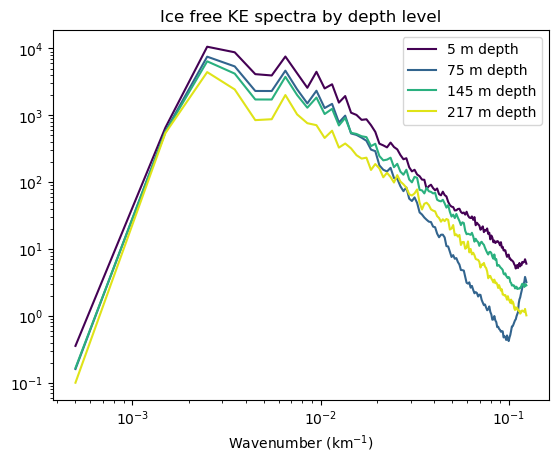

In [130]:
# plot spectra for ice free
colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
for iz in range(nLevs):
    plt.loglog(binCenters,powerSpectrum[0,:,iz,:].mean((0,)), 
               label=f"{-depth[levs[iz]].round(0).astype(int)} m depth", 
               color=colors[iz])
plt.legend()
plt.title("Ice free KE spectra by depth level")
plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")

In [15]:
# plot spectra for ice covered
# colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
# for iz in range(nLevs):
#     plt.loglog(binCenters,powerSpectrum[1,:,iz,:].mean((0,)), 
#                label=f"{-depth[levs[iz]].round(0).astype(int)} m depth", 
#                color=colors[iz])
# plt.legend()
# plt.title("Ice covered KE spectra by depth level")
# plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")

In [16]:

# slope fitting
coef = np.polyfit(np.log10(binCenters[10:90]),
                  np.log10(powerSpectrum[0,:,2,10:90].mean((0,))),
                  1)
fitLine = np.poly1d(coef)
fitFunc = lambda x: 10**(fitLine(np.log10(x)))


fitLine2 = np.poly1d((-3,coef[1]))
fitFunc2 = lambda x: 10**(fitLine2(np.log10(x)))

fitLine3 = np.poly1d((-4,coef[1]-3))
fitFunc3 = lambda x: 10**(fitLine3(np.log10(x)))



In [17]:
coef

array([-2.83584527, -2.37540043])

IndexError: index 1 is out of bounds for axis 0 with size 1

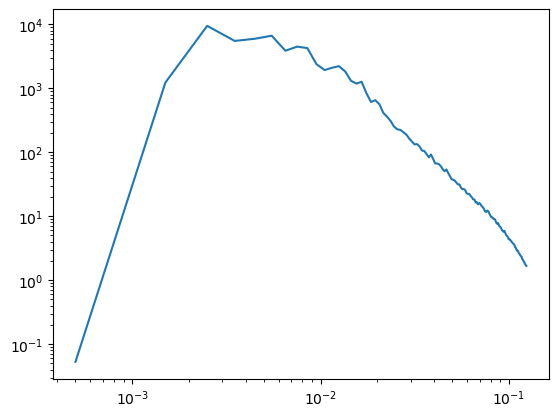

In [18]:
# plot spectra comparing ice free and ice covered
colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
plt.loglog(binCenters,powerSpectrum[0,:,0,:].mean((0,)), 
           label="Ice free")
plt.loglog(binCenters,powerSpectrum[1,:,0,:].mean((0,)), 
           label="Ice covered")
plt.legend()
plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")
plt.title("Surface KE spectra")

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc(binCenters[10:90]), 
         linestyle="dashed", color="grey")


In [ ]:
# plot spectra comparing ice free and ice covered
colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
plt.loglog(binCenters,powerSpectrum[0,:,1,:].mean((0,)), 
           label="Ice free")
plt.loglog(binCenters,powerSpectrum[1,:,1,:].mean((0,)), 
           label="Ice covered")
plt.legend()
plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")
plt.title(f"Depth {-depth[levs[1]].round(0).astype(int)}m KE spectra")

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc(binCenters[10:90]), 
         linestyle="dashed", color="grey")

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc2(binCenters[10:90]), 
         linestyle="dashed", color="black")

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc3(binCenters[10:90]), 
         linestyle="dashed", color="green")

In [ ]:
# plot spectra comparing ice free and ice covered
colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
plt.loglog(binCenters,powerSpectrum[0,:,2,:].mean((0,)), 
           label="Ice free")
plt.loglog(binCenters,powerSpectrum[1,:,2,:].mean((0,)), 
           label="Ice covered")
plt.legend()
plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")
plt.title(f"Depth {-depth[levs[2]].round(0).astype(int)}m KE spectra")

# slope fitting
coef = np.polyfit(np.log10(binCenters[10:90]),
                  np.log10(powerSpectrum[0,:,2,10:90].mean((0,))),
                  1)
fitLine = np.poly1d(coef)
fitFunc = lambda x: 10**(fitLine(np.log10(x)))

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc(binCenters[10:90]), 
         linestyle="dashed", color="grey")

In [ ]:
coef

IndexError: index 1 is out of bounds for axis 0 with size 1

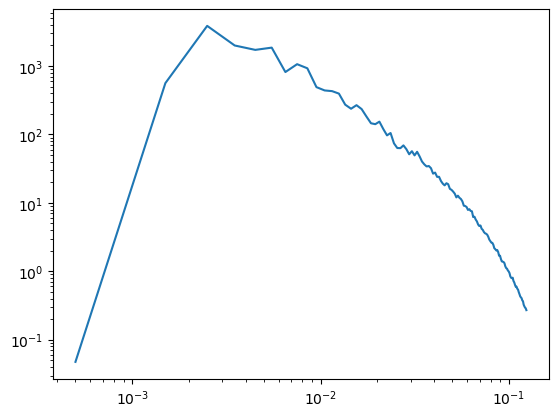

In [19]:
# plot spectra comparing ice free and ice covered
colors = plt.cm.viridis(np.linspace(0,0.95,nLevs))
plt.loglog(binCenters,powerSpectrum[0,:,3,:].mean((0,)), 
           label="Ice free")
plt.loglog(binCenters,powerSpectrum[1,:,3,:].mean((0,)), 
           label="Ice covered")
plt.legend()
plt.xlabel("Wavenumber ($\mathrm{km}^{-1}$)")
plt.title(f"Depth {-depth[levs[3]].round(0).astype(int)}m KE spectra")

# plot fit line
plt.plot((binCenters[10:90]),
         fitFunc(binCenters[10:90]), 
         linestyle="dashed", color="grey")